# 1: Importing Libraries 

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
You should consider upgrading via the 'c:\users\91702\anaconda3\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\91702\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [52]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\91702\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
   

In [4]:
dataset

{'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

# 2: Preprocess Data and View Segmentation Mask

In [5]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.
  mask -=1
  return image, mask

@tf.function
def load_image_train(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  
  image, mask = normalize(image, mask)
  return image, mask

def load_image_test(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  image, mask = normalize(image, mask)
  return image, mask

In [6]:
#training and testing length
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [8]:
#The dataset already contains the required splits of test and train, so let's continue to use the same split

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

### Data Vizualization

In [10]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

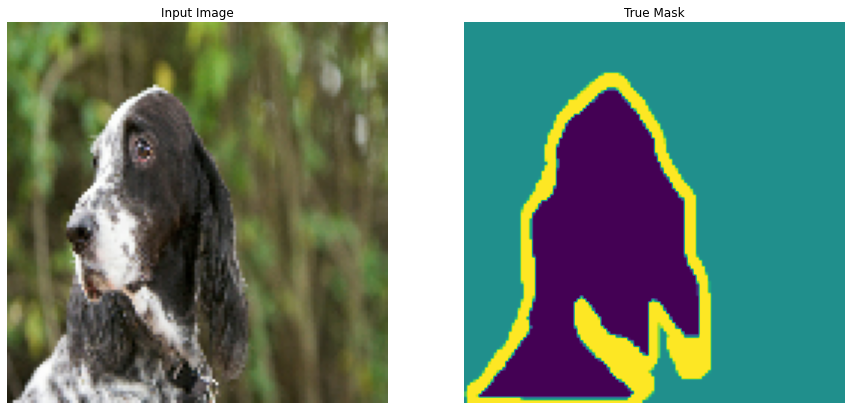

In [60]:
for image, mask in train.take(50):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# 3: Define the model

In [19]:
# loading pre trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False)

names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu',
         'block_13_expand_relu', 'block_16_expand_relu']
layers = [base_model.get_layer(name).output for name in names]

down_sample = tf.keras.Model(base_model.input, layers)
down_sample.trainable = False

In [20]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
inputs = tf.keras.layers.Input(shape=[128,128,3 ])
x = inputs

# Downsampling through the model
skips = down_sample(x)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

# This is the last layer of the model
x = tf.keras.layers.Conv2DTranspose(3, 3, strides=2 , padding='same')(x)  #64x64 -> 128x128

model = tf.keras.Model(inputs, x)

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# 4: Training the model and Visualizing Result

In [23]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [24]:
show_predictions()

NameError: name 'sample_image' is not defined

In [26]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 2

h = model.fit(train_dataset, 
              epochs=EPOCHS,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data=test_dataset,
              callbacks=[DisplayCallback()])

Epoch 1/2


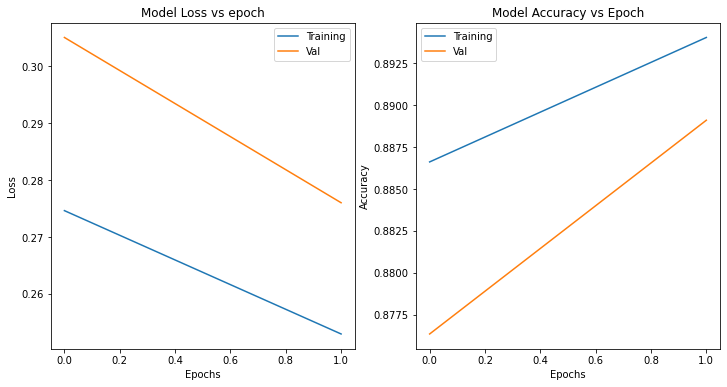

In [72]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h.history['loss'], label='Training')
plt.plot(h.history['val_loss'], label='Val')
plt.title('Model Loss vs epoch')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(h.history['accuracy'], label='Training')
plt.plot(h.history['val_accuracy'], label='Val')
plt.title('Model Accuracy vs Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# 5: VIZULAZING RESULTS

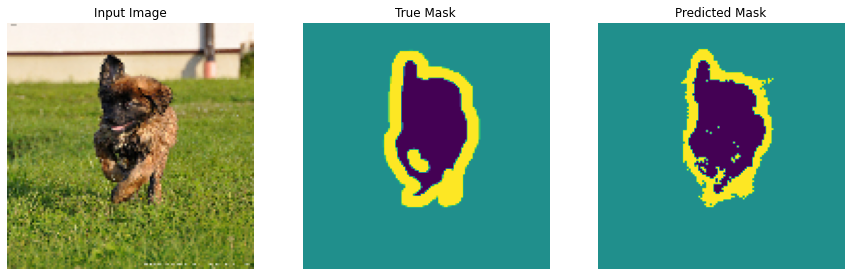

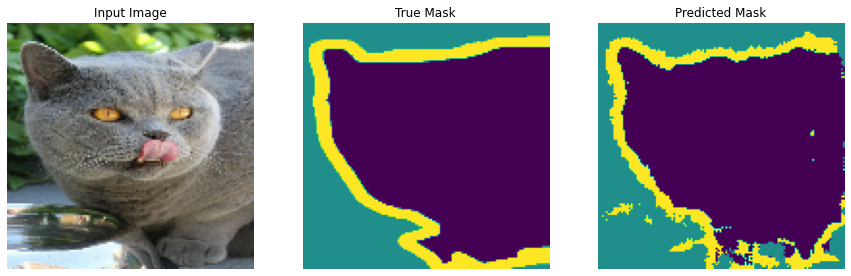

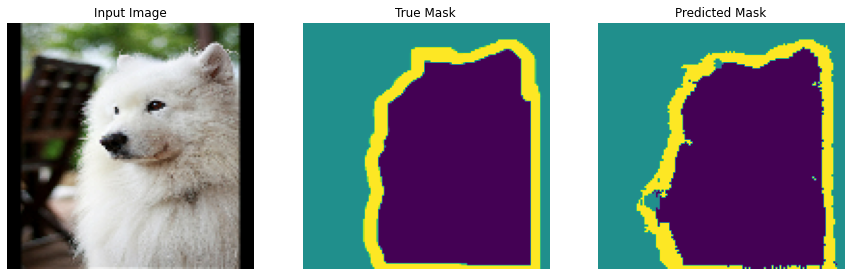

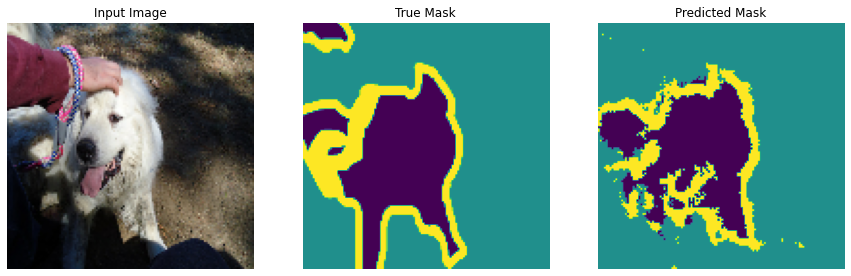

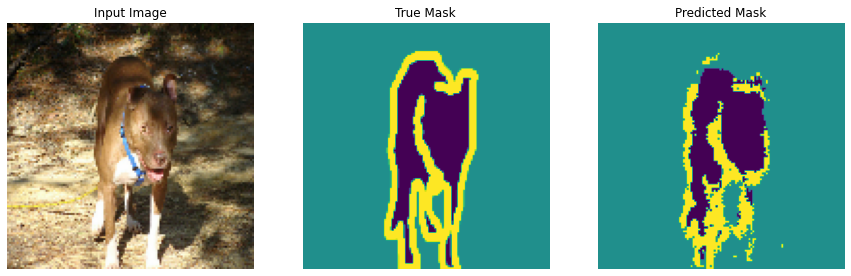

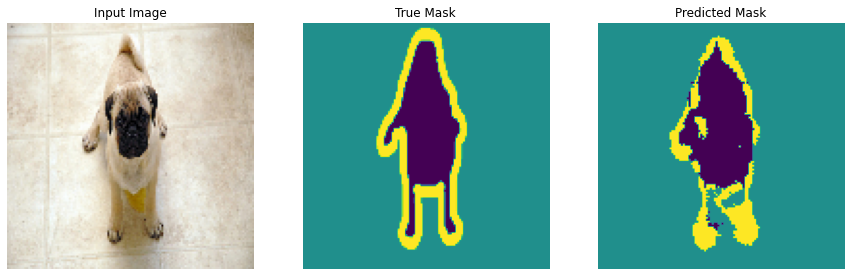

In [73]:
show_predictions(test_dataset, 6)